In [1]:
# Import packages
from helpers import load_all_data, vectorized_flatten, sigmoid, get_log_loss, get_accuracy, sigmoid_derivative, gradient_update, plot_loss
from helpers import sgd_with_momentum_update, prep_data,  get_best_epoch, get_results
import numpy as np

In [2]:
def initialize_two_layers(X, h1): 
    '''
    --------------------
    Parameter Initialization
    --------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X [n = 12000])
    --------------------
    Output: 
    weights: Weight terms initialized as random normals
    biases: Bias terms initialized to zero
    --------------------
    '''
    dim1 = 1/np.sqrt(X.shape[0])
    W1 = dim1 * np.random.randn(h1, 28**2)
    
    dim2 = 1/np.sqrt(W1.shape[1])
    W2 = dim2 * np.random.randn(1, h1)
    
    b1 = np.zeros((h1, 1))
    b2 = np.zeros((1, 1))
    
    weights = (W1, W2)
    biases = (b1, b2)
    
    return weights, biases

In [3]:
def forward_pass_two_layers(X, weights, biases):
    '''
    ----------------------------------
    Forward propogation:
    Send inputs through the network to
    generate output
    ----------------------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X n)
    weights: Binary (1/0) training label (shape = n X 1)
    biases:
    --------------------
    Output: 
    activations: vector of results from passing
    inputs through each neuron
    --------------------
    '''
    W1, W2 = weights
    b1, b2 = biases
    
    z1 = W1 @ X + b1
    a1 = sigmoid(z1)
    
    z2 = W2 @ a1 + b2
    a2 = sigmoid(z2)
    
    activations = (z1, a1, z2, a2)
    
    return activations

In [4]:
def backpropagation_two_layers(X, y, weights, biases, activations):
    '''
    --------------------
    Backpropagation
    --------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X n)
    y: Binary (1/0) training label (shape = n X 1)
    weights: Current set of weights
    biases: Current set of biases
    activations: Current set of activations
    --------------------
    Output: 
    Derivatives required
    for optimization update
    --------------------
    '''
    W1, W2 = weights
    b1, b2 = biases
    z1, a1, z2, a2 = activations
    m = y.shape[1]
    #print(m)   
    
    dz2 = a2 - y
    #print("dz3", dz3.shape)
    
    dW2 = np.dot(dz2, a1.T)/m
    #print("dW2", dW2.shape)
    
    db2 = np.sum(dz2, axis=1).reshape(-1, 1)/m
    #print("db2", db2.shape)
    
    da1 = np.dot(W2.T, dz2)
    #print("da1", da1.shape)
    
    dz1 = da1 * sigmoid_derivative(z1)
    #print("dz1", dz1.shape)
    
    dW1 = np.dot(dz1, X.T)/m
    #print("dW1", dW1.shape)
    
    db1 = np.sum(dz1, axis=1).reshape(-1, 1)/m
    #print("db1", db1.shape)
    
    return db1, dW1, db2, dW2

In [5]:
def finite_differences():
    pass

In [6]:
def update_parameters_without_momentum(weights, biases, gradients, learning_rate):
    '''
    --------------------
    Update parameters
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2 = weights
    b1, b2 = biases
    
    db1, dW1, db2, dW2 = gradients
    
    W1 = gradient_update(W1, learning_rate, dW1)
    W2 = gradient_update(W2, learning_rate, dW2)
   
    b1 = gradient_update(b1, learning_rate, db1)
    b2 = gradient_update(b2, learning_rate, db2)
    
    weights = (W1, W2)
    biases = (b1, b2)
    
    return weights, biases

In [7]:
def initialize_velocity(weights,biases):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2 = weights
    b1, b2 = biases
    vw1 = np.zeros(W1.shape)
    vw2 = np.zeros(W2.shape)
    vb1 = np.zeros(b1.shape)
    vb2 = np.zeros(b2.shape)
    return vw1,vw2,vb1,vb2

In [8]:
def update_parameters_with_momentum(weights,biases,gradients,learning_rate,velocity,momentum):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2 = weights
    b1, b2 = biases
    
    db1, dW1, db2, dW2 = gradients
    vw1,vw2,vb1,vb2 = velocity
    W1,vw1 = sgd_with_momentum_update(W1, learning_rate, dW1,vw1,momentum)
    W2,vw2 = sgd_with_momentum_update(W2, learning_rate, dW2,vw2,momentum)
   
    b1,vb1 = sgd_with_momentum_update(b1, learning_rate, db1,vb1,momentum)
    b2,vb2 = sgd_with_momentum_update(b2, learning_rate, db2,vb2,momentum)
    
    weights = (W1, W2)
    biases = (b1, b2)
    velocity = (vw1,vw2,vb1,vb2)
    return weights ,biases,velocity

In [9]:
def output_layer():
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    y_prob = activations_full[-1]
    y_pred = np.where(y_prob > 0.5, 1, 0)
    
    return(y_prob, y_pred)

In [10]:
def batchify(X):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    pass

In [11]:
def batch_training(batch_size, weights, biases, epochs,
                   X, y, momentum_param, lr, X_dev,y_dev, velocity):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    history = {
        "weights": [weights],
        "losses": [], 
        "biases": [biases],
        "accuracies": [],
        "velocity":[velocity],
        "dev_accuracies" :[],
        "dev_loss":[]
    }
    
    
    for epoch in range(epochs):
        
        offset = 0
        weights = history['weights'][epoch]
        biases = history['biases'][epoch]
        velocity = history['velocity'][epoch]
        
        while offset <max(y.shape):
            if offset%1000==0 :
                print("epoch :",epoch," batch:",offset)
            else :
                a=1
            if offset+batch_size >=max(y.shape):
                X_batch = X[:,offset:]
                y_batch = y[:,offset:]
            else :    
                X_batch = X[:,offset:offset+batch_size]
                y_batch = y[:,offset:offset+batch_size]
            
            activations = forward_pass_two_layers(X_batch, weights, biases)
            gradients = backpropagation_two_layers(X_batch, y_batch, weights, biases, activations)
            weights, biases,velocity = update_parameters_with_momentum(weights, biases, gradients, 
                                                                       lr, velocity, momentum_param)
            offset = offset+batch_size
        
        activations_full = forward_pass_two_layers(X, weights, biases)
        y_prob = activations_full[-1]
        y_pred = np.where(y_prob > 0.5, 1, 0)

        loss = get_log_loss(y, y_prob)
        accuracy = get_accuracy(y, y_pred)
        
        activations_dev = forward_pass_two_layers(X_dev,weights,biases)
        y_dev_prob =  activations_dev[-1]
        y_dev_pred = np.where(y_dev_prob > 0.5, 1, 0)
        
        loss_dev = get_log_loss(y_dev,y_dev_prob)
        accuracy_dev = get_accuracy(y_dev,y_dev_pred)

        history["weights"].append(weights)
        history["losses"].append(loss)
        history["biases"].append(biases)
        history["velocity"].append(velocity)
        history["accuracies"].append(accuracy)
        history["dev_accuracies"].append(accuracy_dev)
        history['dev_loss'].append(loss_dev)

        if np.isnan(loss):
            break
        print("loss after epoch: ",epoch,": ",loss)
    
    return history

In [12]:
def run_training(data_path, epochs, mode, model_name, h1, lr, batch_size, momentum_param):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    # Set seed for reproducible results
    np.random.seed(1252908)
    
    # Get data
    X_train_flattened, X_dev_flattened, X_test_flattened, y_train, y_dev, y_test = prep_data(data_path)
    
    # According to mode
    if mode == 'full': 
        batch_size = max(y_train.shape)
    elif mode == 'stochastic':
        batch_size = 1
    
    # Print to check batch size is correct
    print("The batch size is...{} with mode {}".format(batch_size, mode))
    
    # Initialize weights and biases
    weights, biases = initialize_two_layers(X_train_flattened, h1)
    
    # Call training
    velocity = initialize_velocity(weights, biases)
    history = batch_training(batch_size, weights, biases, 
                             epochs, X_train_flattened, y_train, 
                             momentum_param, lr, X_dev_flattened, y_dev, velocity)
    
    # Get best epoch from history object
    best_epoch = get_best_epoch(history)
    
    # Plot loss and save
    plot_loss("loss_{}.png".format(model_name), history["losses"][:-2])
    
    # Plot accuracy and save
    plot_loss("accuracy_{}.png".format(model_name), history["accuracies"][:-2], label='Training Accuracy')
    
    return(history, best_epoch)

In [28]:
def grid_search(momentum_grid, lr_grid, batch_size_grid, h1):

    best_params = {}
    best_params['loss'] = np.inf
    best_params['momentum'] = 0
    best_params['lr'] = 0
    best_params['batch_size'] = 0
    best_params["weights"] = 0
    best_params["biases"] = 0
    
    for m in momentum_grid:
        for l in lr_grid:
            for bs in batch_size_grid:
                
                weights, biases = initialize(X_train_flattened, h1)
                velocity = initialize_velocity(weights,biases)
                epochs = 50
                
                history = {
                    "weights": [weights],
                    "losses": [], 
                    "biases": [biases],
                    "accuracies": [],
                    "velocity":[velocity]
                }
                
                history = batch_training_with_momentum(bs,weights,biases,history,X_train_flattened,y_train,m,l)
                best_epoch = get_best_epoch(history)
                print(history['accuracies'][best_epoch],best_epoch)
                
                activations_dev = forward_pass(X_dev_flattened, 
                                               history["weights"][best_epoch], 
                                               history["biases"][best_epoch])
                y_prob = activations_dev[-1]
                dev_loss = get_log_loss(y_dev,y_prob)
                
                if dev_loss < best_params['loss'] :
                    best_params['momentum'] = m
                    best_params['lr'] = l
                    best_params['batch_size'] = bs
                    best_params['loss'] = dev_loss
                    best_params["weights"] = history["weights"][best_epoch]
                    best_params["biases"] = history["biases"][best_epoch]
            
    return(best_params)           

In [ ]:
# Set parameters
modes = ['full', 'stochastic', 'mini']
data_path = '../setup/data'
batch_size = 10
epochs = 100 
h1 = 32 
lr = 0.1

In [ ]:
model_name = '..figs/{}_without_momentum'
momentum_param = 0

The batch size is...12000 with mode full
epoch : 0  batch: 0
loss after epoch:  0 :  8271.200264586612
epoch : 1  batch: 0
loss after epoch:  1 :  8257.007938066472
epoch : 2  batch: 0
loss after epoch:  2 :  8236.431169220825
epoch : 3  batch: 0
loss after epoch:  3 :  8209.58810294501
epoch : 4  batch: 0
loss after epoch:  4 :  8176.261813542554
epoch : 5  batch: 0
loss after epoch:  5 :  8135.862272257615
epoch : 6  batch: 0
loss after epoch:  6 :  8087.405748666673
epoch : 7  batch: 0
loss after epoch:  7 :  8029.513611158557
epoch : 8  batch: 0
loss after epoch:  8 :  7960.437280698944
epoch : 9  batch: 0
loss after epoch:  9 :  7878.11498128352
epoch : 10  batch: 0
loss after epoch:  10 :  7780.256707478431
epoch : 11  batch: 0
loss after epoch:  11 :  7664.446376669439
epoch : 12  batch: 0
loss after epoch:  12 :  7528.259619452246
epoch : 13  batch: 0
loss after epoch:  13 :  7369.427990314881
epoch : 14  batch: 0
loss after epoch:  14 :  7186.118288951651
epoch : 15  batch: 0


epoch : 5  batch: 2000
epoch : 5  batch: 3000
epoch : 5  batch: 4000
epoch : 5  batch: 5000
epoch : 5  batch: 6000
epoch : 5  batch: 7000
epoch : 5  batch: 8000
epoch : 5  batch: 9000
epoch : 5  batch: 10000
epoch : 5  batch: 11000
loss after epoch:  5 :  5054.710104310792
epoch : 6  batch: 0
epoch : 6  batch: 1000
epoch : 6  batch: 2000
epoch : 6  batch: 3000
epoch : 6  batch: 4000
epoch : 6  batch: 5000
epoch : 6  batch: 6000
epoch : 6  batch: 7000
epoch : 6  batch: 8000
epoch : 6  batch: 9000
epoch : 6  batch: 10000
epoch : 6  batch: 11000
loss after epoch:  6 :  4751.590208894103
epoch : 7  batch: 0
epoch : 7  batch: 1000
epoch : 7  batch: 2000
epoch : 7  batch: 3000
epoch : 7  batch: 4000
epoch : 7  batch: 5000
epoch : 7  batch: 6000
epoch : 7  batch: 7000
epoch : 7  batch: 8000
epoch : 7  batch: 9000
epoch : 7  batch: 10000
epoch : 7  batch: 11000
loss after epoch:  7 :  3355.4718624483785
epoch : 8  batch: 0
epoch : 8  batch: 1000
epoch : 8  batch: 2000
epoch : 8  batch: 3000
ep

KeyboardInterrupt: 

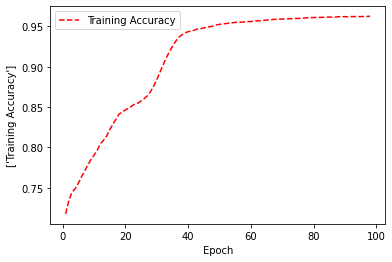

In [32]:
results_without_momentum = {'full':'', 'stochastic':'', 'batch': ''}
    
for mode in modes:
    fig_name = model_name.format(mode)
    results_without_momentum[mode] = run_training(data_path, 
                                                  epochs, mode, model_name, h1, 
                                                  lr, batch_size, momentum_param)

In [ ]:
# Set parameters
model_name = '../figs/{}_without_momentum'
momentum_param = 0.9

In [ ]:
results_with_momentum = {'full':'', 'stochastic':'', 'batch': ''}
    
for mode in modes:
    fig_name = model_name.format(mode)
    results_with_momentum[mode] = run_training(data_path, 
                                                  epochs, mode, model_name, h1, 
                                                  lr, batch_size, momentum_param)

In [ ]:
# Store grids for grid search
momentum = np.arange(0.001,0.01,0.001)
lr = np.arange(0.01,0.1,0.01)
batch_size = [16,64,256,1024,4096]